<a href="https://colab.research.google.com/github/worldwidekatie/DS-Unit-1-Sprint-3-Linear-Algebra/blob/master/module4-clustering/LS_DS_134_Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df_orig = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df_orig.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [7]:
#To make my life easier later
test = df_orig['diagnosis']
test1 = test.replace({"M": 0, "B": 1})
test2 = test.replace({"M": 1, "B": 0})

print(test1.describe())
print(test2.describe())

count    569.000000
mean       0.627417
std        0.483918
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: diagnosis, dtype: float64
count    569.000000
mean       0.372583
std        0.483918
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: diagnosis, dtype: float64


## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [9]:
df = df_orig.drop(['diagnosis', 'id', 'Unnamed: 32'], axis=1)
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


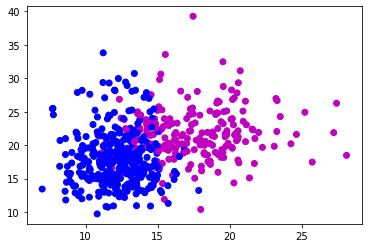

In [22]:
#Scatterplot of the first two columns
plt.scatter(df_orig['radius_mean'], df_orig['texture_mean'], c=df_orig['diagnosis'])
plt.show();

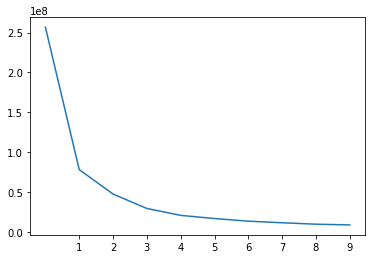

In [18]:
#Where I make a copy of the dataframe so I don't screw it up
x = df.values

#Elbow Plot
distortion = []
for k in range(1,11):
  kmeans = KMeans(k)
  kmeans.fit(x)
  distortion.append(kmeans.inertia_)

plt.plot(distortion)
plt.xticks(range(1,10))
plt.show();

In [23]:
#Finding the K-Means
#first, instantiate kmeans and I'm doing 2 clusters 
#because I have 2 label possibilities
kmeans = KMeans(n_clusters=2)
kmeans.fit(x)
print(kmeans.labels_)


[1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 1
 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 1 1 

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [26]:
df['k_labels'] = kmeans.labels_
print("K-Means Solo Accuracy")
(df['k_labels'] == test1).value_counts()[0] /df.shape[0]

K-Means Solo Accuracy


0.8541300527240774

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



## I started out with the 90% of variance approach and then read the directions that I have to do other stuff so that's below.

In [0]:
#Instantiate the scaler
scaler = StandardScaler()
#Then make the z-scores (which is how you standardize it)
z = scaler.fit_transform(x)

In [0]:
#Instantiate a PCA using .9 if you want to keep 90% of the variance
#And accept however many PC's that creates
pca = PCA(.9)
pca_data = pca.fit_transform(z)

In [63]:
#Look at the eigenvalues if you feel like it
pca.explained_variance_

array([13.30499079,  5.7013746 ,  2.82291016,  1.98412752,  1.65163324,
        1.20948224,  0.67640888])

In [64]:
#Check how much of the variance you've kept
print("We've retained 91% of the variance with 7 groups")
sum(pca.explained_variance_ratio_)

We've retained 91% of the variance with 7 groups


0.9100953006967308

In [65]:
#Now to test how accurate it is to compare to K-Means alone
#First make a copy of the data that's a numpy array
y = pca_data
#instantiate kmeans w/ desired number of predicted groups
kmeans = KMeans(n_clusters=2)
kmeans.fit(y)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [66]:
# Now test it
df['pca_labels'] = kmeans.labels_
print("K-Means PCA Accuracy with 90% of explained variance")
(df['pca_labels'] == test1).value_counts()[0] /df.shape[0]

K-Means PCA Accuracy with 90% of explained variance


0.08963093145869948

##Here goes for just two groups

In [43]:
#Have to start at the very beginning to re-define z
scaler = StandardScaler()
z = scaler.fit_transform(x)
pca = PCA(2)
pca_data = pca.fit_transform(z)
#Check to make sure it only did two
pca.explained_variance_

array([13.30499079,  5.7013746 ])

In [45]:
print("We've retained 63% of the variance with 2 groups")
sum(pca.explained_variance_ratio_)

We've retained 63% of the variance with 2 groups


0.6324320765155951

In [50]:
#Now do k-means stuff on it
j = pca_data
kmeans = KMeans(n_clusters=2)
kmeans.fit(j)

df['pca_labels'] = kmeans.labels_
print("K-Means PCA Accuracy with 63% of explained variance")
(df['pca_labels'] == test1).value_counts()[0] /df.shape[0]

K-Means PCA Accuracy with 63% of explained variance


0.9068541300527241

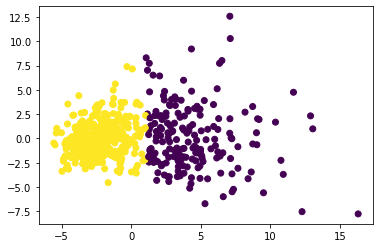

In [48]:
#Do my scatterplot
pca_df = pd.DataFrame(pca_data)
pca_df['label'] = df['pca_labels']
plt.scatter(pca_df[0], pca_df[1], c=pca_df['label'])
plt.show();

###Scree Plot


In [0]:
#I re-ran the cells for the 90% variance before running this
#Because I thought it made a more interesting screeplot than just two
#TBH I don't understand everything happening in the this code cell.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

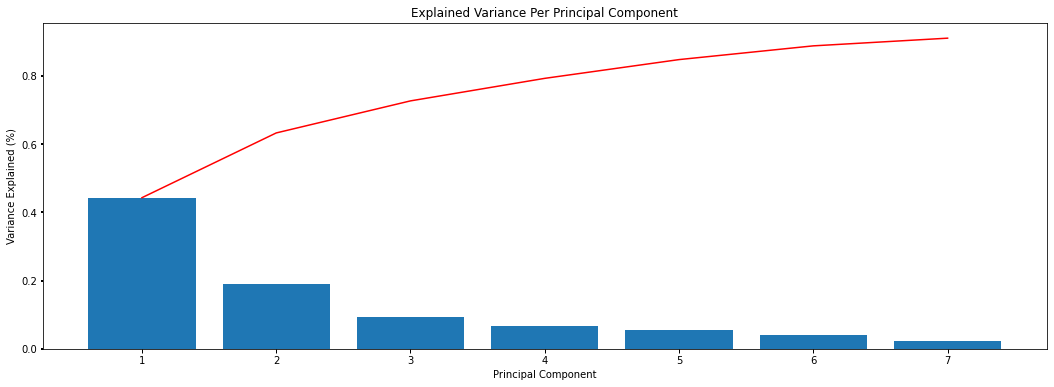

In [75]:
# Define screeplot function
def scree_plot():
  plt.figure(figsize=(18,6))
  ax = plt.subplot(111)

  ax.xaxis.set_tick_params(width=1)
  ax.yaxis.set_tick_params(width=2, length=2)

  ax.set_xticklabels(['0','1', '2', '3', '4', '5', '6', '7'])
  
  ax.set_xlabel("Principal Component")
  ax.set_ylabel("Variance Explained (%)")
  plt.title("Explained Variance Per Principal Component")

  ax.bar(ind,vals)
  ax.plot(ind, cumvals, c='r')
  
  
  plt.show()

scree_plot()

## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

In [41]:
pca_df = pd.DataFrame(pca_data)
pca_df['label'] = df['pca_labels']

pca_df.head(1)

,0,1,2,3,4,5,6,label
0,9.192837,1.948583,-1.123166,3.633731,-1.19511,1.411424,2.15937,1


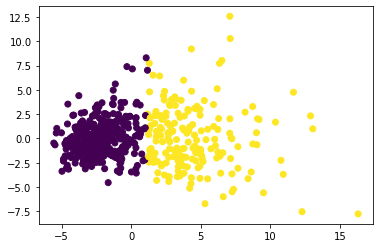

In [38]:
#Scatterplot of the first two columns
plt.scatter(pca_df[0], pca_df[1], c=pca_df['label'])
plt.show();

#**In conclusion**
### K-Means by itself yielded an 85% accuracy in spotting malignent vs benign tumors and the scatterplot was not well defined as two groups


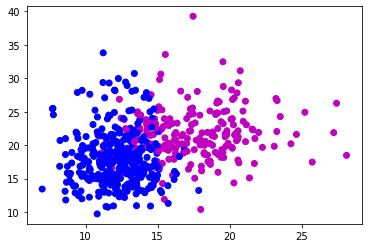

In [39]:
plt.scatter(df_orig['radius_mean'], df_orig['texture_mean'], c=df_orig['diagnosis'])
plt.show();

### By using PCA, with seven columns to include <91% of the variance, accuracy increased to 91% and the scatterplot was much more defined as two groups

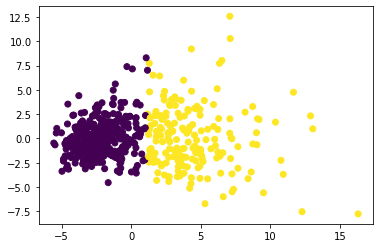

In [40]:
plt.scatter(pca_df[0], pca_df[1], c=pca_df['label'])
plt.show();

### Using PCA with only two columns included only 63% of the variance yet was still 91% accurate and the scatterplot is also very defined into two groups. 

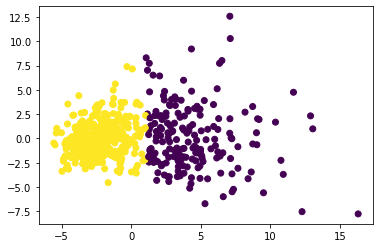

In [51]:
plt.scatter(pca_df[0], pca_df[1], c=pca_df['label'])
plt.show();

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project